# Knapsack Solution using Genetic Algorithm
## Mukai Wang 98830336

We first generate 1000 items with weight and value both between 10 and 100. We set the weight limit to be 200.

In [37]:
import numpy as np
import random
min_weight = 10
max_weight = 100
min_value=10
max_value = 100
num_item = 1000
limit = 200
random.seed(2022)

In [38]:
item_weights = np.random.randint(low=min_weight, high=max_weight, size=num_item)
item_values = np.random.randint(low=min_value, high=max_value, size=num_item)
item_vwratios = item_values / item_weights

Define value function and weight function. The genotypes are binary vectors.

In [39]:
def calc_weight(genotype):
    return np.sum(item_weights[genotype])

def calc_value(genotype):
    return np.sum(item_values[genotype])

def ifvalid(genotype):
    return calc_weight(genotype) <= limit

I define the fitness value of a valid solution to be $value*(1+\frac{1}{Number of Items})$. A choice with very high value and very few items is worth exploring. An invalid solution has a fitness value of zero.

In [40]:
def fitness(genotype):
    return calc_value(genotype) * ifvalid(genotype) * (1+1/np.sum(genotype))

Let's randomly generate 20 individuals as the first generation.

In [41]:
individuals = np.zeros((num_item, 20)).astype(bool)

In [42]:
def search(start):
    """
    Given a genotype vector, try to add as many items into it as possible without exceeding weight limit
    """
    # initial valid choices
    current_weight = calc_weight(start) # starting weight
    choices = np.logical_and(np.logical_not(start), item_weights <= limit - current_weight) # find all plausible choices
    current_choice = start # starting point
    while choices.any():
        indices = np.where(choices)[0]
        newmember = random.choices(indices, weights=item_vwratios[indices], k=1)
        current_choice[newmember] = True
        current_weight += item_weights[newmember]
        choices = np.logical_and(np.logical_not(current_choice), item_weights <= limit - current_weight)
    return current_choice

Define the mutation function to randomly remove one item from the knapsack and add others into it.

In [43]:
def mutation(currentsac):
    current_choices = np.where(currentsac)[0]
    member_to_remove = random.choice(current_choices)
    currentsac[member_to_remove] = False
    # then add new items into it
    return search(currentsac)

Define the recombination function to choose pairs of individuals from the current generation and exchange part of knapsacks to have the next generations. The choices of individuals are weighted based on fitness.

In [44]:
def recombination(oldgen):
    
    indv_weights = np.apply_along_axis(fitness, 0, oldgen)
    newgen = np.zeros((num_item, 20)).astype(bool)
    
    for j in range(20):
        parents = np.random.choice(np.arange(0, 20), size=2, replace=False, p = indv_weights/sum(indv_weights))
        p1 = oldgen[:, parents[0]]
        p2 = oldgen[:, parents[1]]
        split_position = random.choice(np.arange(0, num_item))
        desc1 = np.concatenate((p1[0:split_position], p2[split_position: num_item]), axis=None)
        desc2 = np.concatenate((p2[0:split_position], p1[split_position: num_item]), axis=None)
        desc_genotypes = [desc1, desc2]
        desc_fitness = np.array([fitness(desc1), fitness(desc2)])
        chosen_desc = random.choices([0, 1], weights = desc_fitness, k=1)
        newgen[:, j] = desc_genotypes[chosen_desc[0]]
    
    return newgen

In [45]:
def gen_summary(gen):
    """
    summarize the values of this generation
    """
    gen_values = np.apply_along_axis(calc_value, 0, gen)
    gen_best = gen[:, np.argmax(gen_values)]
    gen_best_value = calc_value(gen_best)
    gen_mean_value = np.mean(gen_values)
    gen_std_value = np.std(gen_values)
    return gen_mean_value, gen_best, gen_best_value, gen_std_value

Initiate the 0th generation.

In [46]:
current_gen = np.apply_along_axis(search, 0, individuals)
current_gen_mean, current_gen_best, current_gen_best_value, current_gen_std_value = gen_summary(current_gen)
temporary_best = current_gen_best
temporary_best_value = current_gen_best_value
avg_values = np.zeros(43)
best_values = np.zeros(43)
std_values = np.zeros(43)
avg_values[0] = current_gen_mean
best_values[0] = current_gen_best_value
std_values[0] = current_gen_std_value

Repeat 20 generations.

In [48]:
import time
t0 = time.time()
for iteration in range(21):
    
    next_gen = recombination(current_gen) # use recombination to generate next generation
    next_gen_mean, next_gen_best, next_gen_best_value, next_gen_std_value = gen_summary(next_gen)
    avg_values[iteration*2+1] = next_gen_mean
    best_values[iteration*2+1] = next_gen_best_value
    std_values[iteration*2+1] = next_gen_std_value
    
    if next_gen_best_value > temporary_best_value: # update the best record when needed
        temporary_best = next_gen_best
        temporary_best_value = next_gen_best_value
    
    mutate_gen = np.apply_along_axis(mutation, 0, next_gen)
    mutate_gen_mean, mutate_gen_best, mutate_gen_best_value, mutate_gen_std_value = gen_summary(mutate_gen)
    avg_values[iteration*2+2] = mutate_gen_mean
    best_values[iteration*2+2] = mutate_gen_best_value
    std_values[iteration*2+2] = mutate_gen_std_value
    
    if mutate_gen_best_value > temporary_best_value:
        temporary_best = mutate_gen_best
        temporary_best_value = mutate_gen_best_value
    
    current_gen = mutate_gen
t1 = time.time()
print("20 generations of iteration took {:.3f} seconds".format(t1-t0))

20 generations of iteration took 0.084 seconds


Plot the iteration of the average value and the best value.

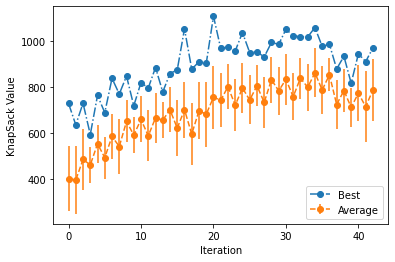

In [49]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0, 43), best_values, 'o-.' ,label = "Best")
plt.errorbar(np.arange(0, 43), avg_values, yerr=std_values, fmt = 'o--', label = "Average")
plt.legend(loc='lower right')
plt.xlabel("Iteration")
plt.ylabel("KnapSack Value")
plt.show()

Check the optimal solution.

In [50]:
print("The highest value is {}".format(temporary_best_value))

The highest value is 1109


In [51]:
print("The total weight for the best knapsack is {}".format(calc_weight(temporary_best)))

The total weight for the best knapsack is 200


In [52]:
print("The total number of items in the best knapsack is {}".format(np.sum(temporary_best)))

The total number of items in the best knapsack is 15


Check out the item weights and values.

In [53]:
itemids = np.where(temporary_best)[0]
for item in itemids:
    w = item_weights[item]
    v = item_values[item]
    print("Item {} has a value of {} and weight of {}".format(item, v, w))

Item 72 has a value of 86 and weight of 16
Item 105 has a value of 75 and weight of 12
Item 222 has a value of 39 and weight of 11
Item 344 has a value of 92 and weight of 13
Item 400 has a value of 79 and weight of 10
Item 571 has a value of 69 and weight of 26
Item 599 has a value of 85 and weight of 15
Item 604 has a value of 91 and weight of 18
Item 679 has a value of 30 and weight of 10
Item 826 has a value of 87 and weight of 10
Item 854 has a value of 85 and weight of 12
Item 862 has a value of 80 and weight of 12
Item 877 has a value of 99 and weight of 11
Item 893 has a value of 29 and weight of 10
Item 923 has a value of 83 and weight of 14
